This project is aimed to predict energy consumption based on datetime and American Electric Power estimated energy consumption in Megawatts (MW) using Prophet.

In [2]:
import pandas as pd
from prophet import Prophet

c:\Users\romer\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we import the data

In [3]:
df=pd.read_csv("AEP_hourly.csv")

Let's visualize the data

In [4]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [5]:
df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [6]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [7]:
df.isnull().any()

Datetime    False
AEP_MW      False
dtype: bool

Now that we have correctly imported the data, it's time to clean the data for a EDA.

In [8]:
# The day and hour are in the same column so we need to split them
def split_datetime(column,sep):
    return column.str.split(sep,expand=True)

In [9]:
dateAndHour=split_datetime(df["Datetime"]," ")
dateAndHour.head()

,0,1
0,2004-12-31,01:00:00
1,2004-12-31,02:00:00
2,2004-12-31,03:00:00
3,2004-12-31,04:00:00
4,2004-12-31,05:00:00


In [10]:
yymmdd=split_datetime(dateAndHour[0],"-")
yymmdd

,0,1,2
0,2004,12,31
1,2004,12,31
2,2004,12,31
3,2004,12,31
4,2004,12,31
...,...,...,...
121268,2018,01,01
121269,2018,01,01
121270,2018,01,01
121271,2018,01,01


The hour only has one part of our interest, we can confirm this by using **unique()** method

In [11]:
dateAndHour[1].unique()

array(['01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00',
       '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00',
       '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00',
       '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00',
       '21:00:00', '22:00:00', '23:00:00', '00:00:00'], dtype=object)

Let's extract the hour only

In [12]:
#for that we are using 0 at the end of the cell below
hour=split_datetime(dateAndHour[1],":")[0] 
hour

0         01
1         02
2         03
3         04
4         05
          ..
121268    20
121269    21
121270    22
121271    23
121272    00
Name: 0, Length: 121273, dtype: object

The next thing to do is to merge all the dataframes into a single one

In [29]:
data=pd.concat([df["AEP_MW"],dateAndHour,yymmdd,hour],axis=1)

In [30]:
data

,AEP_MW,0,1,0,1,2,0
0,13478.0,2004-12-31,01:00:00,2004,12,31,01
1,12865.0,2004-12-31,02:00:00,2004,12,31,02
2,12577.0,2004-12-31,03:00:00,2004,12,31,03
3,12517.0,2004-12-31,04:00:00,2004,12,31,04
4,12670.0,2004-12-31,05:00:00,2004,12,31,05
...,...,...,...,...,...,...,...
121268,21089.0,2018-01-01,20:00:00,2018,01,01,20
121269,20999.0,2018-01-01,21:00:00,2018,01,01,21
121270,20820.0,2018-01-01,22:00:00,2018,01,01,22
121271,20415.0,2018-01-01,23:00:00,2018,01,01,23


For simplicity, the columns have to be renamed, for better readability

In [31]:
columnNames=["Energy consumed","Date","Hour/Minutes/Seconds","Year","Month","Day","Hour"]
data.columns=columnNames

Finally we can see our clean data

In [32]:
data

,Energy consumed,Date,Hour/Minutes/Seconds,Year,Month,Day,Hour
0,13478.0,2004-12-31,01:00:00,2004,12,31,01
1,12865.0,2004-12-31,02:00:00,2004,12,31,02
2,12577.0,2004-12-31,03:00:00,2004,12,31,03
3,12517.0,2004-12-31,04:00:00,2004,12,31,04
4,12670.0,2004-12-31,05:00:00,2004,12,31,05
...,...,...,...,...,...,...,...
121268,21089.0,2018-01-01,20:00:00,2018,01,01,20
121269,20999.0,2018-01-01,21:00:00,2018,01,01,21
121270,20820.0,2018-01-01,22:00:00,2018,01,01,22
121271,20415.0,2018-01-01,23:00:00,2018,01,01,23


In [33]:
data.dtypes

Energy consumed         float64
Date                     object
Hour/Minutes/Seconds     object
Year                     object
Month                    object
Day                      object
Hour                     object
dtype: object

With the clean data, it's time to plot and see the energy consumption

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

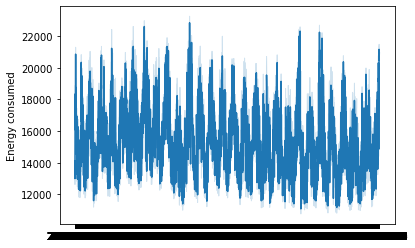

In [20]:
sns.lineplot(x="Date",y="Energy consumed",data=data)
plt.show()

In [40]:
yearKW=data.groupby(by="Year").sum()
yearKW

,Energy consumed
Year,
2004,33479854.0
2005,138752914.0
2006,137826610.0
2007,145781458.0
2008,145224910.0
2009,133595510.0
2010,140187481.0
2011,138511181.0
2012,134814172.0


As it's seen the year 2004 ans 2018 are incomplete. This can be seen in the code below.

In [48]:
subset2004=data[data["Year"]=="2004"]
len(subset2004["Date"].unique())

92

Only 92 days are recorded for 2004.

Let's do the same for 2018

In [49]:
subset2018=data[data["Year"]=="2018"]
len(subset2018.Date.unique())

215

This year has only 215 days recorded, so if we want to compare the energy consumption, we need to delete records from 2004 and 2018

In [59]:
completeYearRecords=data[(data["Year"]!="2004") & (data["Year"]!="2018")]
completeYearRecordsGrouped=completeYearRecords.groupby("Year").sum()
completeYearRecordsGrouped

,Energy consumed
Year,
2005,138752914.0
2006,137826610.0
2007,145781458.0
2008,145224910.0
2009,133595510.0
2010,140187481.0
2011,138511181.0
2012,134814172.0
2013,133105937.0


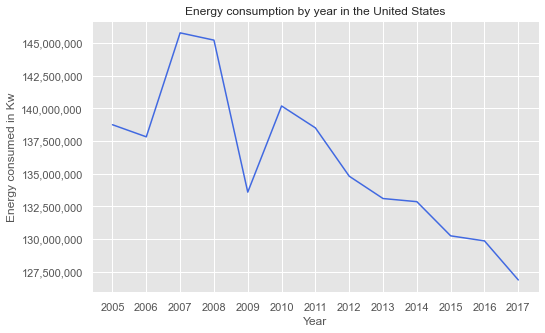

In [91]:
plt.style.use("ggplot")
sns.lineplot(x="Year",y="Energy consumed",data=completeYearRecordsGrouped,color="royalblue")
sns.set(rc={'figure.figsize':(8,5)})
plt.title("Energy consumption by year in the United States")
plt.ylabel("Energy consumed in Kw")
valores_con_comas = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in valores_con_comas])
plt.show()